In [49]:
!pip install skshapes pyvista

## Imports

In [50]:
import os

os.environ["JAXTYPING_DISABLE"] = "1"

import skshapes as sks
import pyvista as pv
import numpy as np
import torch
import pyvista as pv
from IPython.display import Image

## Prepare toy data

### Utils

In [51]:
# --- 2. 3D PHYSICS FUNCTION ---
def apply_3d_retraction(mesh, center, strength=0.5, sigma=4.0):
    """
    Apply a 3D retraction force towards a center point.
    Works on PyVista meshes.
    """
    points = np.array(mesh.points)
    vectors = points - center
    distances = np.linalg.norm(vectors, axis=1)
    
    # Avoid division by zero
    distances = np.where(distances == 0, 0.001, distances)
    unit_vectors = vectors / distances[:, None]
    
    # Gaussian-shaped displacement
    displacement = strength * distances * np.exp(-(distances**2) / (2 * sigma**2))
    
    # Apply deformation
    new_points = points - (unit_vectors * displacement[:, None])
    
    # Return a new mesh with updated points
    deformed_mesh = mesh.copy()
    deformed_mesh.points = new_points
    return deformed_mesh

# --- 3. SHAPE GENERATORS ---

def get_liver_3d():
    # Create a base sphere and scale it to look like a liver lobe
    liver = pv.Sphere(radius=5.0, phi_resolution=50, theta_resolution=50)
    liver = liver.scale([1.8, 1.0, 0.7], inplace=False)
    return liver

def get_vessel_3d(center_ablation):
    # Points de contrôle décalés pour contourner la zone d'ablation (rayon 2.2)
    # On s'assure que la distance au centre est toujours > 2.5
    path_points = np.array([
        [-3.0,  3.0,  0.5],  # En haut à gauche
        [ 0.0,  3.0,  0.0],  # Passe au dessus
        [ 3.0,  0.0, -1.0],  # Contourne par la droite
        [ 2.0, -3.0,  0.0],  # Redescend
        [-2.0, -4.0,  0.5]   # Sortie en bas
    ]) + center_ablation
    
    spline = pv.Spline(path_points, 50)
    return spline.tube(radius=0.25)

def validate_setup(liver, tumor, ablation, vessel):
    """
    Validation script to ensure anatomical constraints are met.
    """
    print("--- Geometry Validation Report ---")
    
    def check_inside(inner_mesh, outer_mesh):
        # Returns the percentage of points from inner_mesh contained in outer_mesh
        select = inner_mesh.select_enclosed_points(outer_mesh)
        return select['SelectedPoints'].view(bool).mean() * 100

    # 1. Vessel inside Liver
    v_in_l = check_inside(vessel, liver)
    print(f"Vessel inside Liver: {v_in_l:.1f}%")

    # 2. Vessel outside Ablation Zone
    v_in_a = check_inside(vessel, ablation)
    print(f"Vessel inside Ablation Zone: {v_in_a:.1f}% (Should be 0.0%)")

    # 3. Tumor inside Ablation Zone
    t_in_a = check_inside(tumor, ablation)
    print(f"Tumor inside Ablation Zone: {t_in_a:.1f}%")

    # 4. Ablation Zone inside Liver
    a_in_l = check_inside(ablation, liver)
    print(f"Ablation Zone inside Liver: {a_in_l:.1f}%")

    # Global status
    is_valid = (v_in_l == 100) and (v_in_a == 0) and (t_in_a == 100) and (a_in_l == 100)
    if is_valid:
        print("\n✅ SETUP VALID: All anatomical constraints are satisfied.")
    else:
        print("\n❌ SETUP INVALID: Please adjust positions or scales.")


### Create the data

In [52]:
# --- 4. PARAMÈTRES ET GÉNÉRATION ---
center_point = np.array([2.0, 1.0, 0.0])
tumor_radius, ablation_radius = 1.2, 2.2

# PRE-OP
liver_pre = get_liver_3d()
tumor_pre = pv.Sphere(radius=tumor_radius, center=center_point)
ablation_pre = pv.Sphere(radius=ablation_radius, center=center_point)
vessel_pre = get_vessel_3d(center_point)

# Run the validation
validate_setup(
    liver=liver_pre, 
    tumor=tumor_pre, 
    ablation=ablation_pre, 
    vessel=vessel_pre
)

# POST-OP
liver_post = apply_3d_retraction(liver_pre, center_point)
tumor_post = apply_3d_retraction(tumor_pre, center_point)
ablation_post = apply_3d_retraction(ablation_pre, center_point)
vessel_post = apply_3d_retraction(vessel_pre, center_point)

--- Geometry Validation Report ---
Vessel inside Liver: 100.0%
Vessel inside Ablation Zone: 0.0% (Should be 0.0%)
Tumor inside Ablation Zone: 100.0%
Ablation Zone inside Liver: 100.0%

✅ SETUP VALID: All anatomical constraints are satisfied.


### Visualisation

Affichage des vues successives...


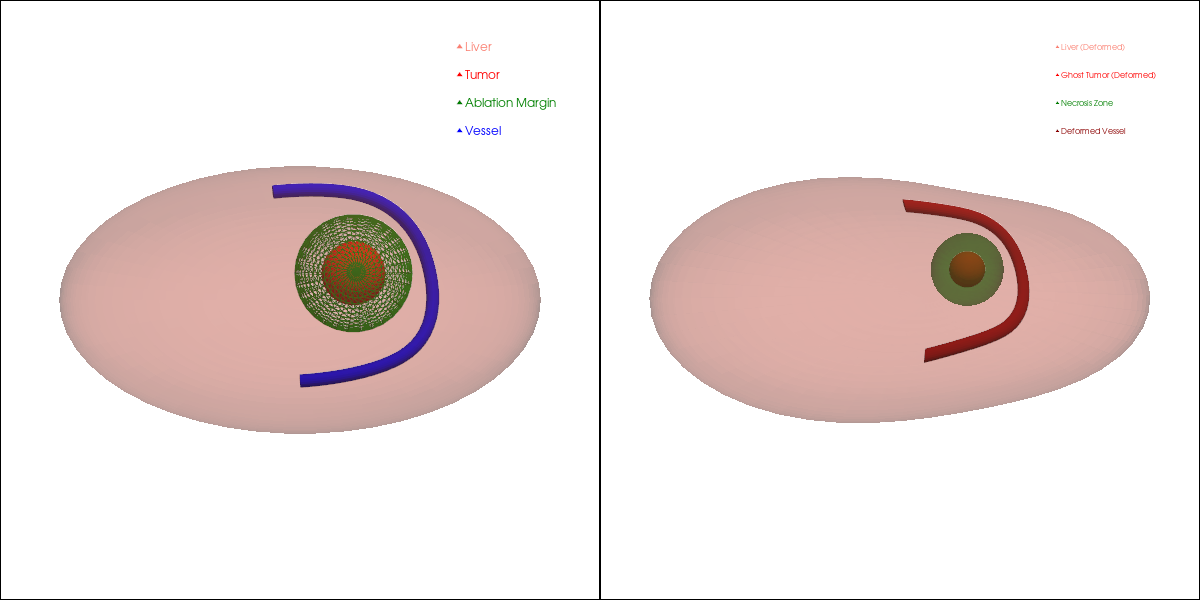

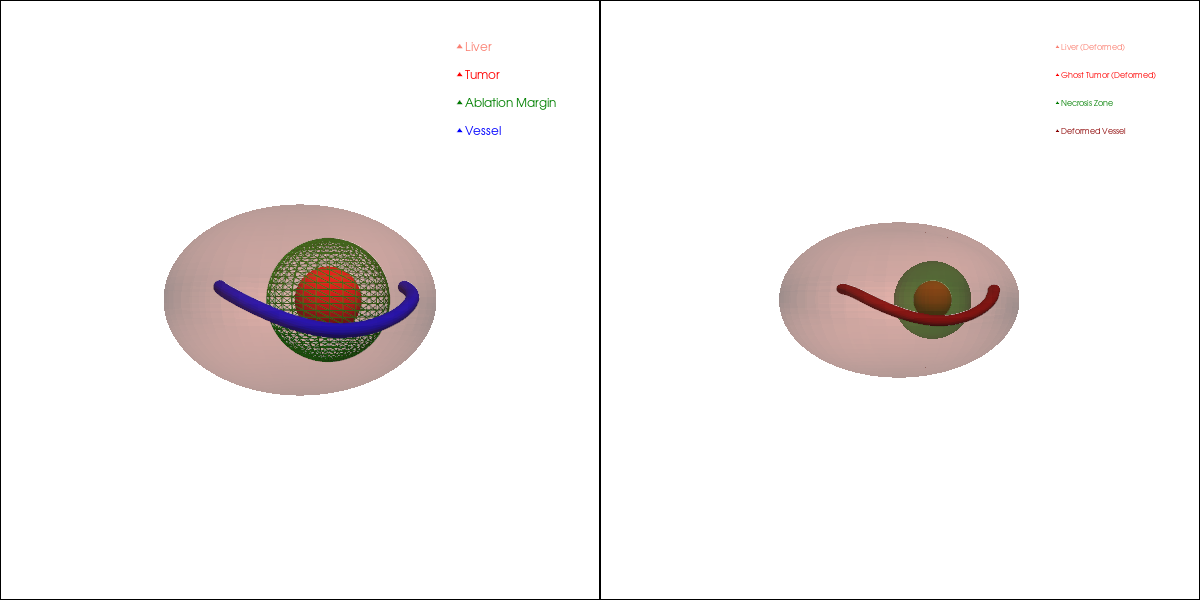

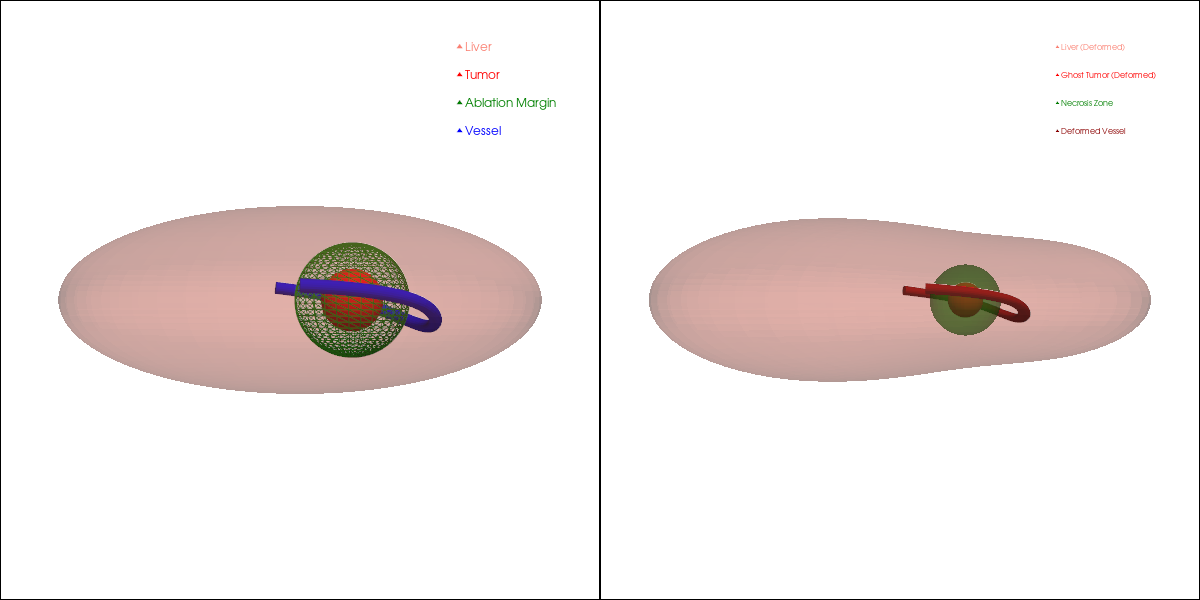

In [53]:
def render_comparison(view_name, view_func):
    filename = f"view_{view_name}.png"
    plotter = pv.Plotter(shape=(1, 2), off_screen=True, window_size=[1200, 600])
    
    # --- SUBPLOT 0: PRE-OP ---
    plotter.subplot(0, 0)
    plotter.add_text(f"PRE-OP: {view_name}", font_size=12, color="white")
    plotter.add_mesh(liver_pre, color="salmon", opacity=0.3, label="Liver")
    plotter.add_mesh(tumor_pre, color="red", label="Tumor")
    plotter.add_mesh(ablation_pre, color="green", style="wireframe", label="Ablation Margin")
    plotter.add_mesh(vessel_pre, color="blue", label="Vessel")
    plotter.add_legend(face=None) # Legend sans fond pour plus de clarté
    view_func(plotter) # Applique l'angle de caméra (XY, YZ ou XZ)

    # --- SUBPLOT 1: POST-OP ---
    plotter.subplot(0, 1)
    plotter.add_text(f"POST-OP: {view_name}", font_size=12, color="white")
    plotter.add_mesh(liver_post, color="salmon", opacity=0.3, label="Liver (Deformed)")
    plotter.add_mesh(tumor_post, color="red", label="Ghost Tumor (Deformed)")
    plotter.add_mesh(ablation_post, color="green", opacity=0.5, label="Necrosis Zone")
    plotter.add_mesh(vessel_post, color="darkred", label="Deformed Vessel")
    plotter.add_legend(face=None)
    view_func(plotter)

    # Sauvegarde et affichage
    plotter.screenshot(filename)
    plotter.close()
    display(Image(filename))

# --- 6. EXÉCUTION SUCCESSIVE ---

print("Affichage des vues successives...")

# Vue de Face
render_comparison("Front View (XY)", lambda p: p.view_xy())

# Vue de Profil
render_comparison("Side View (YZ)", lambda p: p.view_yz())

# Vue de Dessus
render_comparison("Top View (XZ)", lambda p: p.view_xz())

## Registration ("recalage" en français)

### Create full structures

In [54]:
# Structure 1 & 2: Registration (Liver + Vessel)
# These are the structures of which we know the correspondence
pre_known_structure = sks.PolyData(liver_pre + vessel_pre)
post_known_structure = sks.PolyData(liver_post + vessel_post)

# Structure 3 & 4: Full (Liver + Vessel + Tumor)
pre_full_structure = sks.PolyData(liver_pre + vessel_pre + tumor_pre)
post_full_structure = sks.PolyData(liver_post + vessel_post + ablation_post)

In [55]:
# --- 3. HIGH DEFINITION REGISTRATION (3D) ---

source = pre_known_structure
target = post_known_structure

# Define a 3D control grid
# N=15 gives 15x15x15 = 3,375 control points
source.control_points = source.bounding_grid(N=15, offset=0.1)

model = sks.ExtrinsicDeformation(
    n_steps=5,         # Fewer steps for speed in 3D
    kernel="gaussian",
    scale=2.0,         # Scale must be larger in 3D to cover the volume
    control_points=True
)

registration = sks.Registration(
    model=model,
    loss=sks.OptimalTransportLoss(),
    optimizer=sks.LBFGS(),
    n_iter=30,
    regularization_weight=0.01, # Higher reg for 3D stability
    verbose=True
)

print(f"Number of 3D control points: {source.control_points.n_points}")
morphed = registration.fit_transform(source=source, target=target)

Number of 3D control points: 3375
Initial loss : 4.88e-01
  = 4.88e-01 + 0.01 * 0.00e+00 (fidelity + regularization_weight * regularization)
Loss after 1 iteration(s) : 5.75e-02
  = 1.50e-02 + 0.01 * 4.25e+00 (fidelity + regularization_weight * regularization)
Loss after 2 iteration(s) : 5.72e-02
  = 1.47e-02 + 0.01 * 4.25e+00 (fidelity + regularization_weight * regularization)
Loss after 3 iteration(s) : 5.72e-02
  = 1.47e-02 + 0.01 * 4.25e+00 (fidelity + regularization_weight * regularization)
Loss after 4 iteration(s) : 5.72e-02
  = 1.47e-02 + 0.01 * 4.25e+00 (fidelity + regularization_weight * regularization)
Loss after 5 iteration(s) : 5.72e-02
  = 1.47e-02 + 0.01 * 4.25e+00 (fidelity + regularization_weight * regularization)
Loss after 6 iteration(s) : 5.72e-02
  = 1.47e-02 + 0.01 * 4.25e+00 (fidelity + regularization_weight * regularization)
Loss after 7 iteration(s) : 5.72e-02
  = 1.47e-02 + 0.01 * 4.25e+00 (fidelity + regularization_weight * regularization)
Loss after 8 iterat

In [57]:
# --- Préparation des composants séparés ---

# On récupère le paramètre optimisé
best_parameter = registration.parameter_

# 1. Déformer le foie seul
liver_to_morph = sks.PolyData(liver_pre)
# CRUCIAL : On greffe la grille d'origine
liver_to_morph.control_points = source.control_points 
morph_liver = registration.model.morph(shape=liver_to_morph, parameter=best_parameter)
liver_morphed_pv = morph_liver.morphed_shape.to_pyvista()

# 2. Déformer le vaisseau seul
vessel_to_morph = sks.PolyData(vessel_pre)
vessel_to_morph.control_points = source.control_points
morph_vessel = registration.model.morph(shape=vessel_to_morph, parameter=best_parameter)
vessel_morphed_pv = morph_vessel.morphed_shape.to_pyvista()

# 3. Déformer la tumeur fantôme
tumor_to_morph = sks.PolyData(tumor_pre)
tumor_to_morph.control_points = source.control_points
morph_tumor = registration.model.morph(shape=tumor_to_morph, parameter=best_parameter)
tumor_morphed_pv = morph_tumor.morphed_shape.to_pyvista()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/skshapes/input_validation/converters.py:105: UserWarning: Mesh has been cleaned and points were removed. point_data is ignored.
  return func(*bound_args.args, **bound_args.kwargs)


In [40]:
# 1. On prépare la structure de validation
structure_validation = pre_full_structure

# 2. CRUCIAL : On lui donne la même grille de points de contrôle 
# que celle utilisée par la source lors du registration.fit_transform
structure_validation.control_points = source.control_points

# 3. Maintenant, le morphing va comprendre qu'il doit déplacer 
# la grille (3375 pts) pour déformer l'objet (4244 pts)
validation_morphing = registration.model.morph(
    shape=structure_validation,
    parameter=registration.parameter_
)

full_morphed = validation_morphing.morphed_shape

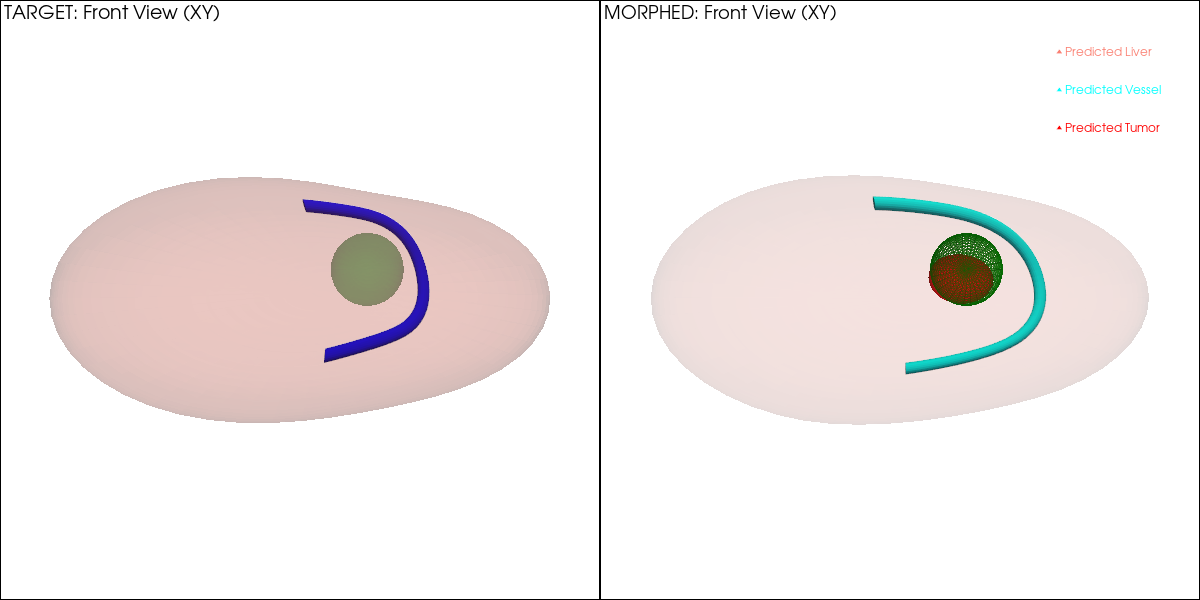

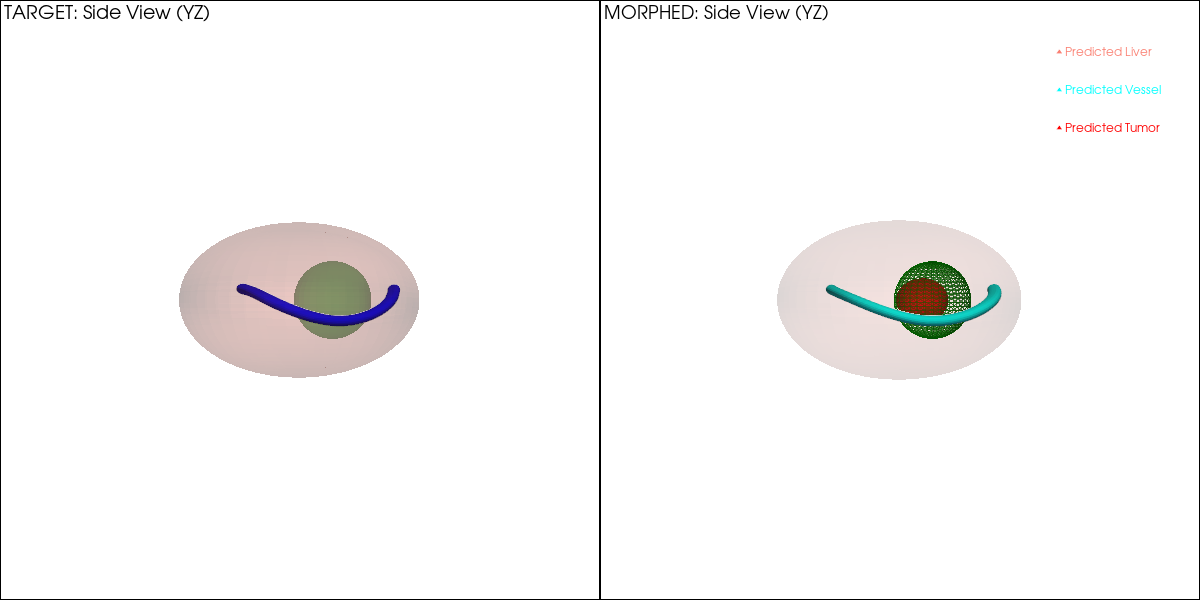

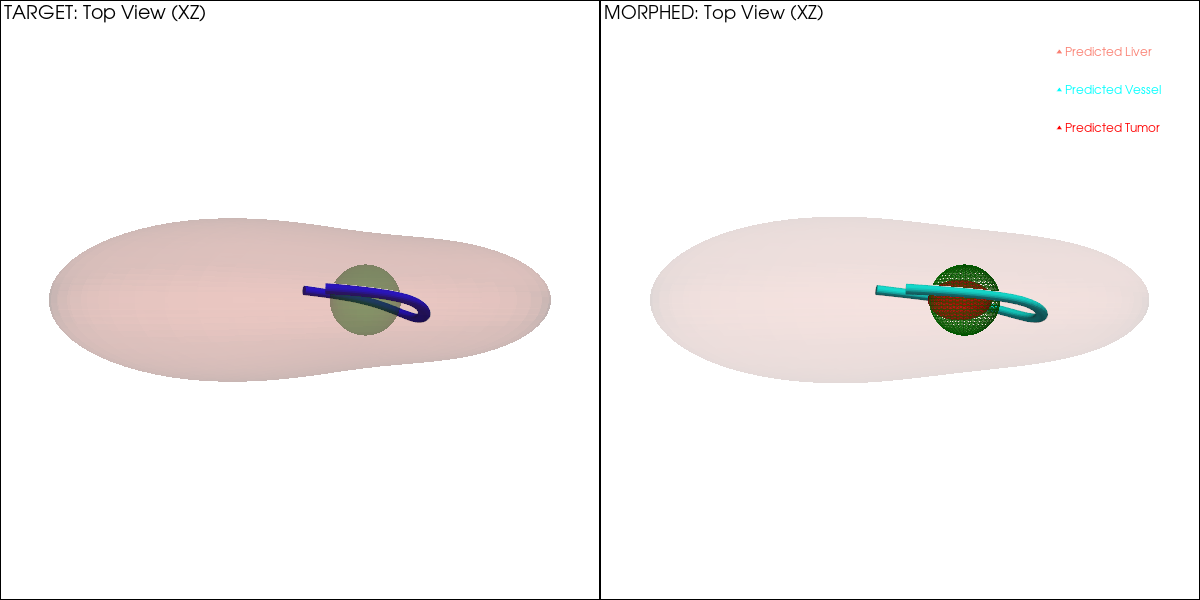

In [61]:
def render_validation_hd(view_name, view_func):
    filename = f"val_hd_{view_name}.png"
    plotter = pv.Plotter(shape=(1, 2), off_screen=True, window_size=[1200, 600])
    
    # --- GAUCHE : TARGET (Vérité terrain simulée) ---
    plotter.subplot(0, 0)
    plotter.add_text(f"TARGET: {view_name}", font_size=10)
    plotter.add_mesh(liver_post, color="salmon", opacity=0.2)
    plotter.add_mesh(vessel_post, color="blue", label="Vessel Real")
    plotter.add_mesh(ablation_post, color="green", opacity=0.3)
    view_func(plotter)
    
    # --- DROITE : MORPHED (Prédiction du recalage) ---
    plotter.subplot(0, 1)
    plotter.add_text(f"MORPHED: {view_name}", font_size=10)
    
    # On affiche le foie très transparent
    plotter.add_mesh(liver_morphed_pv, color="salmon", opacity=0.1, label="Predicted Liver")
    
    # ON AFFICHE LE VAISSEAU EN BLEU FLASHY POUR LE DISTINGUER
    plotter.add_mesh(vessel_morphed_pv, color="cyan", line_width=5, label="Predicted Vessel")
    
    # On affiche la tumeur fantôme en rouge
    plotter.add_mesh(tumor_morphed_pv, color="red", opacity=0.8, label="Predicted Tumor")
    
    # On ajoute la zone d'ablation réelle en fil de fer pour comparer
    plotter.add_mesh(ablation_post, color="green", style="wireframe", opacity=0.5)

    plotter.add_legend()
    view_func(plotter)
    plotter.screenshot(filename)
    plotter.close()
    display(Image(filename))

# Vue de Face
render_validation_hd("Front View (XY)", lambda p: p.view_xy())
render_validation_hd("Side View (YZ)", lambda p: p.view_yz())
render_validation_hd("Top View (XZ)", lambda p: p.view_xz())


In [62]:
# 1. Grille initiale (Source)
grid_pre = source.control_points.to_pyvista()

# 2. Grille déformée (Morphed)
# 'morphed' contient les points de contrôle déplacés par le recalage
grid_post = morphed.control_points.to_pyvista()

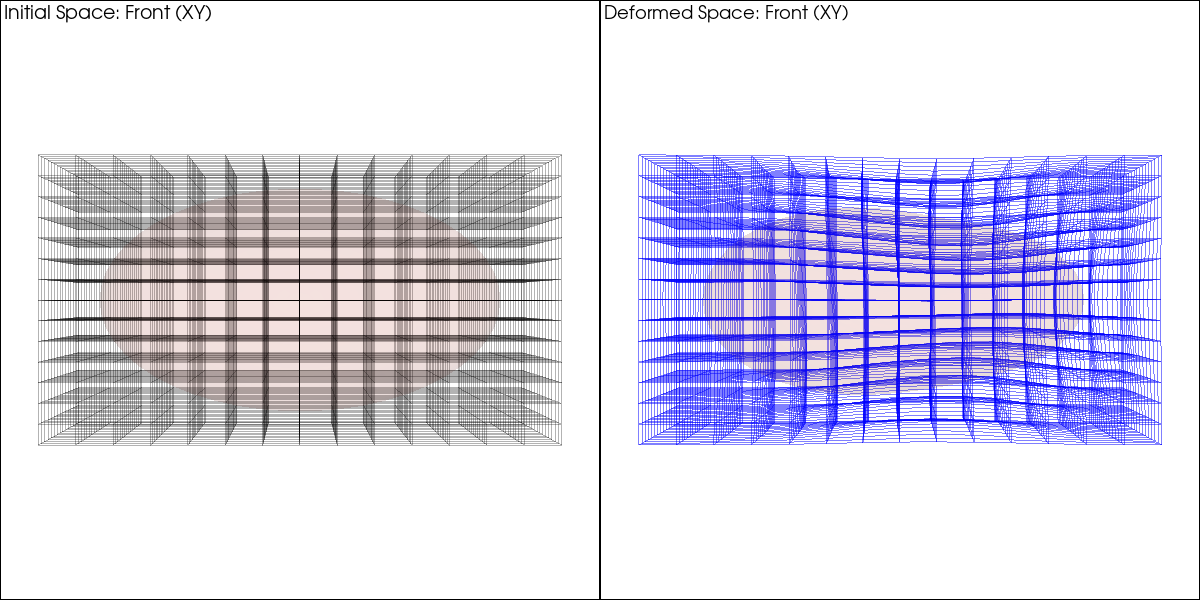

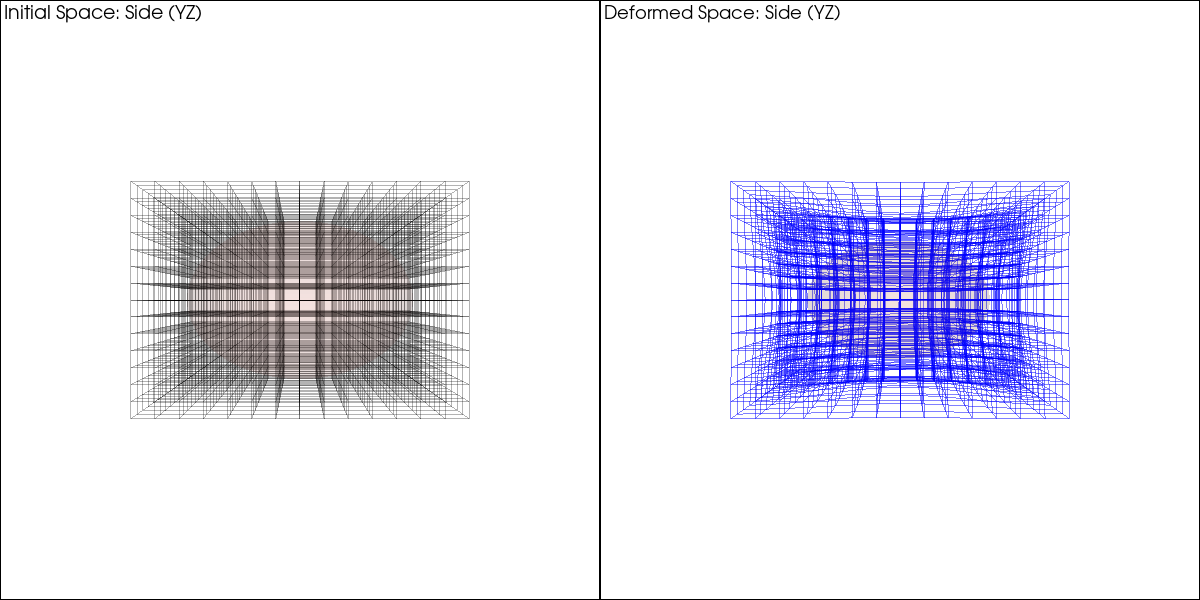

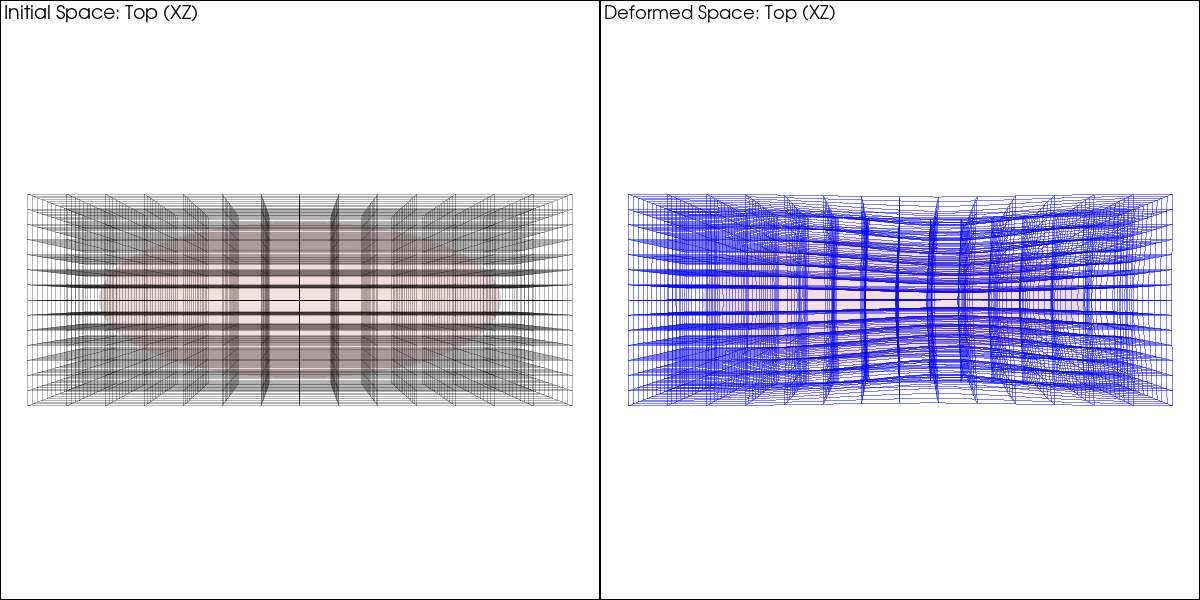

In [63]:
def render_grid_deformation_3d(view_name, view_func):
    filename = f"grid_deform_{view_name}.png"
    plotter = pv.Plotter(shape=(1, 2), off_screen=True, window_size=[1200, 600])
    
    # --- SUBPLOT 0: GRILLE INITIALE ---
    plotter.subplot(0, 0)
    plotter.add_text(f"Initial Space: {view_name}", font_size=10)
    # On affiche le foie en très transparent pour voir la grille à travers
    plotter.add_mesh(liver_pre, color="salmon", opacity=0.1)
    # La grille en noir, style wireframe
    plotter.add_mesh(grid_pre, color="black", style="wireframe", 
                     line_width=1, opacity=0.3, label="Initial Grid")
    view_func(plotter)

    # --- SUBPLOT 1: GRILLE DÉFORMÉE ---
    plotter.subplot(0, 1)
    plotter.add_text(f"Deformed Space: {view_name}", font_size=10)
    plotter.add_mesh(liver_post, color="salmon", opacity=0.1)
    # La grille déformée : on verra les lignes se resserrer vers le centre (rétraction)
    plotter.add_mesh(grid_post, color="blue", style="wireframe", 
                     line_width=1, opacity=0.5, label="Deformed Grid")
    view_func(plotter)

    plotter.screenshot(filename)
    plotter.close()
    display(Image(filename))

# Exécution pour la vue de face
render_grid_deformation_3d("Front (XY)", lambda p: p.view_xy())
render_grid_deformation_3d("Side (YZ)", lambda p: p.view_yz())
render_grid_deformation_3d("Top (XZ)", lambda p: p.view_xz())